In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import plot_confusion_matrix
from wordcloud import WordCloud 
import os

In [2]:
dataFrame = pd.read_csv('complaints_processed.csv')

In [3]:
dataFrame.head(10)

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...
5,5,credit_reporting,payment history missing credit report made mis...
6,6,credit_reporting,va date complaint experian credit bureau invol...
7,7,credit_reporting,account reported abbreviated name full name se...
8,8,credit_reporting,account reported abbreviated name full name se...
9,9,credit_reporting,usdoexxxx account reported abbreviated name fu...


In [4]:
dataFrame = dataFrame.sample(frac =.25)

In [5]:
dataFrame.shape

(40605, 3)

In [6]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40605 entries, 10741 to 2099
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40605 non-null  int64 
 1   product     40605 non-null  object
 2   narrative   40603 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [7]:
#Checking NAN values
print('Missing Values:',dataFrame.isna().sum())

Missing Values: Unnamed: 0    0
product       0
narrative     2
dtype: int64


In [8]:
#There are four classes 
print('Product Counts:\n',dataFrame['product'].value_counts())

Product Counts:
 credit_reporting       22677
debt_collection         5778
mortgages_and_loans     4813
credit_card             3896
retail_banking          3441
Name: product, dtype: int64


In [9]:
# Analysing dataframe attributes 
print('* Datatype of columns are:\n {}\n'.format(dataFrame.dtypes))

* Datatype of columns are:
 Unnamed: 0     int64
product       object
narrative     object
dtype: object



In [10]:
#Since there are very few missing values, we can drop them
dataFrame.dropna(axis=0,inplace=True)

In [11]:
dataFrame.isna().sum()

Unnamed: 0    0
product       0
narrative     0
dtype: int64

In [12]:
# Removing SNo column
dataFrame.drop(['Unnamed: 0'], axis=1, inplace=True)
dataFrame.head()

,product,narrative
10741,credit_reporting,case reporting credit file reference credit ca...
56763,credit_reporting,inquiry showing start authorize im blue face w...
68461,credit_reporting,pulled credit alerted social security card get...
28955,credit_reporting,victim identity notified collection creditor s...
145778,credit_reporting,transunion violation fair credit understanding...


In [13]:
dataFrame.dropna(axis=0,inplace=True)

In [14]:
dataFrame.shape

(40603, 2)

# Exploratory Data Analysis

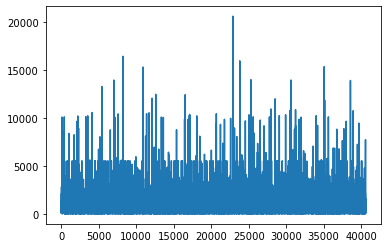

In [15]:
# Plotting word lenghts of narrative
word_length = [len(x) for x in dataFrame['narrative']]
plt.plot(word_length)

In [16]:
# Types of products
dataFrame['product'].value_counts()

credit_reporting       22676
debt_collection         5777
mortgages_and_loans     4813
credit_card             3896
retail_banking          3441
Name: product, dtype: int64

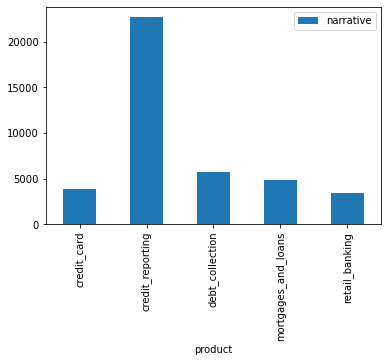

In [17]:
# Plotting product value counts
dataFrame.groupby('product').count().plot(kind='bar')
plt.show()

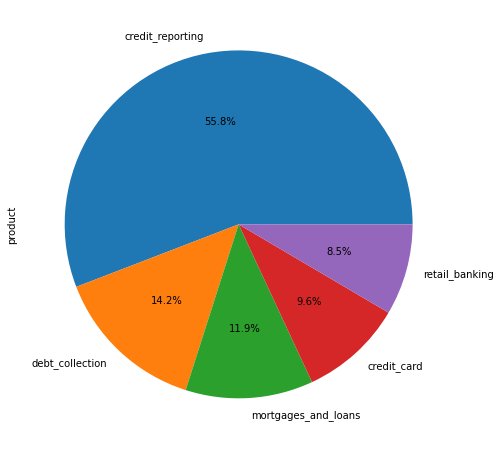

In [18]:
plt.figure(figsize=(10,8))
dataFrame['product'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

/Users/ashish/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


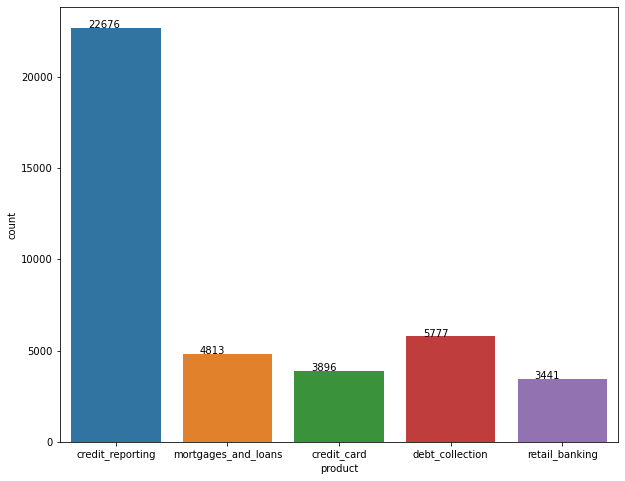

In [19]:
dataFrame['product'].nunique()
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
s=sns.countplot('product', data = dataFrame)
for s in ax.patches:
    ax.annotate('{:.0f}'.format(s.get_height()), (s.get_x()+0.15, s.get_height()+1))
plt.show()

# Text Cleaning

In [20]:
dataFrame["narrative"]=dataFrame["narrative"].str.lower()

In [21]:
dataFrame['narrative'] = dataFrame['narrative'].str.replace("[^a-zA-Z]", " ")

<ipython-input-21-8d05994bbb2e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dataFrame['narrative'] = dataFrame['narrative'].str.replace("[^a-zA-Z]", " ")


In [22]:
dataFrame['narrative'] = dataFrame['narrative'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))

In [23]:
def remove_spaces(data):
    res = re.sub(' +', ' ',data)
    return res

In [24]:
dataFrame['narrative']=dataFrame['narrative'].apply(remove_spaces)

### Tokenization

In [25]:
from nltk.tokenize import word_tokenize
dataFrame['narrative'] = dataFrame['narrative'].astype(str)
dataFrame['narrative'] = dataFrame['narrative'].apply(lambda x: nltk.word_tokenize(x))

## Removal of stopwords

In [26]:
from nltk.corpus import stopwords
s = set(stopwords.words('english'))
# Removing Stopwords
def remove_stopwords(data):
    txt_clean=[w for w in data if w not in s]
    return txt_clean

In [27]:
dataFrame['narrative']=dataFrame['narrative'].apply(lambda x : remove_stopwords(x))

## Stemming

### Lemmatization

In [28]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
dataFrame['narrative']= dataFrame['narrative'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

## WordCloud

In [29]:
# Converting Categorical values into Numerical Vaues
dict = {'credit_reporting' : 1, 'debt_collection' : 2 , 'mortgages_and_loans' : 3, 'credit_card' : 4, 'retail_banking' : 5}
         
# Print the dictionary
print(dict)
  
# Remap the values of the dataframe
dataFrame.replace({"product": dict},inplace=True)

{'credit_reporting': 1, 'debt_collection': 2, 'mortgages_and_loans': 3, 'credit_card': 4, 'retail_banking': 5}


In [30]:
dataFrame.head()

,product,narrative
10741,1,"[case, reporting, credit, file, reference, cre..."
56763,1,"[inquiry, showing, start, authorize, blue, fac..."
68461,1,"[pulled, credit, alerted, social, security, ca..."
28955,1,"[victim, identity, notified, collection, credi..."
145778,1,"[transunion, violation, fair, credit, understa..."


## Train Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(dataFrame['narrative'],dataFrame['product'], test_size=0.2, random_state=42,stratify=dataFrame['product'])

In [32]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [33]:
X_train['narrative']=X_train['narrative'].apply(str)

## Feature extraction
#### Using Bag of Words Technique we are going to convert text into numeric form

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vec = CountVectorizer(lowercase=False)
X_train['narrative']=X_train['narrative'].apply(str)
bow1 = bow_vec.fit_transform(X_train['narrative'])

In [35]:
X_test['narrative']=X_test['narrative'].apply(str)
bow2 = bow_vec.transform(X_test['narrative'])

In [37]:
type(X_test)

pandas.core.frame.DataFrame

In [38]:
X_test=pd.DataFrame(bow2.toarray())
X_train=pd.DataFrame(bow1.toarray())

In [39]:
y_train

4892      1
112323    1
121093    4
23897     1
133269    1
         ..
79123     3
44954     2
14505     1
28533     1
51266     1
Name: product, Length: 32482, dtype: int64

In [42]:
dataFrame['product'].value_counts()

1    22676
2     5777
3     4813
4     3896
5     3441
Name: product, dtype: int64

## Model Building

## Model Buidling Using Bag of Words Technique

## 1.Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier
model1=RandomForestClassifier()
model1.fit(X_train, y_train)

RandomForestClassifier()

## 2. Decision Tree Classifier

In [63]:
model2= DecisionTreeClassifier()
model2.fit(X_train, y_train)

DecisionTreeClassifier()

## 3. Logistics Regression

In [65]:
model3=LogisticRegression( )
model3.fit(X_train, y_train)

/Users/ashish/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Model Testing

In [67]:
# testing
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

In [68]:
# Model Evaluation
print("---------------------------Model 1(RFC)--------------------")
print(classification_report(y_test, pred1))
print("---------------------------Model 2(DTC)--------------------")
print(classification_report(y_test, pred2))
print("---------------------------Model 3(LR)--------------------")
print(classification_report(y_test, pred3))

---------------------------Model 1(RFC)--------------------
              precision    recall  f1-score   support

           1       0.83      0.97      0.89      4535
           2       0.84      0.56      0.67      1156
           3       0.85      0.73      0.78       963
           4       0.79      0.56      0.65       779
           5       0.82      0.78      0.80       688

    accuracy                           0.83      8121
   macro avg       0.83      0.72      0.76      8121
weighted avg       0.83      0.83      0.82      8121

---------------------------Model 2(DTC)--------------------
              precision    recall  f1-score   support

           1       0.85      0.89      0.87      4535
           2       0.65      0.60      0.63      1156
           3       0.72      0.66      0.69       963
           4       0.64      0.60      0.62       779
           5       0.70      0.69      0.70       688

    accuracy                           0.78      8121
   macro av

## Model Buidling Using TF-IDF Technique

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False)
dataFrame['narrative']=dataFrame['narrative'].apply(str)
tfid = vectorizer.fit_transform(dataFrametaFrame['narrative'])
tfid

<40603x23581 sparse matrix of type '<class 'numpy.float64'>'
	with 1961309 stored elements in Compressed Sparse Row format>

### Dividing Data into Training and Test data sets

In [73]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(tfid,dataFrame['product'],random_state=42, test_size=0.3,stratify=dataFrame['product'])

## Random forest classfier

In [74]:
model4=RandomForestClassifier()
model4.fit(x_train1, y_train1)

RandomForestClassifier()

## Decision Tree Classifier

In [75]:
model5= DecisionTreeClassifier()
model5.fit(x_train1, y_train1)

DecisionTreeClassifier()

## Logistic Regression

In [76]:
model6=LogisticRegression()
model6.fit(x_train1, y_train1)

/Users/ashish/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [77]:
pred4= model4.predict(x_test1)
pred5= model5.predict(x_test1)
pred6= model6.predict(x_test1)

In [78]:
print("---------------------------Model 1(RFC)--------------------")
print(classification_report(y_test1, pred4))
print("---------------------------Model 2(DTC)--------------------")
print(classification_report(y_test1, pred5))
print("---------------------------Model 3(LR)--------------------")
print(classification_report(y_test1, pred6))

---------------------------Model 1(RFC)--------------------
              precision    recall  f1-score   support

           1       0.83      0.97      0.89      6803
           2       0.87      0.55      0.67      1733
           3       0.85      0.74      0.79      1444
           4       0.81      0.58      0.68      1169
           5       0.83      0.80      0.81      1032

    accuracy                           0.83     12181
   macro avg       0.84      0.73      0.77     12181
weighted avg       0.83      0.83      0.82     12181

---------------------------Model 2(DTC)--------------------
              precision    recall  f1-score   support

           1       0.85      0.88      0.86      6803
           2       0.62      0.60      0.61      1733
           3       0.70      0.66      0.68      1444
           4       0.58      0.56      0.57      1169
           5       0.68      0.66      0.67      1032

    accuracy                           0.76     12181
   macro av

## Model Testing

In [81]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,pred3)
s=accuracy_score(y_test,pred3)
print("Accuracy Score of model3 by using Bag of words",round(s*100,2))

Accuracy Score of model3 by using Bag of words 84.3


In [43]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

/Users/ashish/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [44]:
y_pred = classifier.predict(X_test)

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[4228  166   88   43   10]
 [ 299  763   48   34   12]
 [ 137   46  747   16   17]
 [  98   32   22  546   81]
 [  28   15   18   65  562]]


In [46]:
print("Confusion Matrix:\n\n",confusion_matrix(y_test,y_pred))
print("\n")
print("Classification Report:\n\n",classification_report(y_test,y_pred))

Confusion Matrix:

 [[4228  166   88   43   10]
 [ 299  763   48   34   12]
 [ 137   46  747   16   17]
 [  98   32   22  546   81]
 [  28   15   18   65  562]]


Classification Report:

               precision    recall  f1-score   support

           1       0.88      0.93      0.91      4535
           2       0.75      0.66      0.70      1156
           3       0.81      0.78      0.79       963
           4       0.78      0.70      0.74       779
           5       0.82      0.82      0.82       688

    accuracy                           0.84      8121
   macro avg       0.81      0.78      0.79      8121
weighted avg       0.84      0.84      0.84      8121



In [47]:
#Using RandomForest Classifier

rfc = RandomForestClassifier(n_jobs=-1)
rfc_model = rfc.fit(X_train,y_train)

In [48]:
#Create Pridiction
prediction = rfc_model.predict(X_test)

In [49]:
print("Confusion Matrix:\n\n",confusion_matrix(y_test,prediction))
print("\n")
print("Classification Report:\n\n",classification_report(y_test,prediction))

Confusion Matrix:

 [[4398   77   37   14    9]
 [ 449  644   37   19    7]
 [ 197   32  703   11   20]
 [ 207   11   29  451   81]
 [  48    7   14   68  551]]


Classification Report:

               precision    recall  f1-score   support

           1       0.83      0.97      0.89      4535
           2       0.84      0.56      0.67      1156
           3       0.86      0.73      0.79       963
           4       0.80      0.58      0.67       779
           5       0.82      0.80      0.81       688

    accuracy                           0.83      8121
   macro avg       0.83      0.73      0.77      8121
weighted avg       0.83      0.83      0.82      8121



Text(0.5, 1.0, 'Confusion Matrix')

<Figure size 720x720 with 0 Axes>

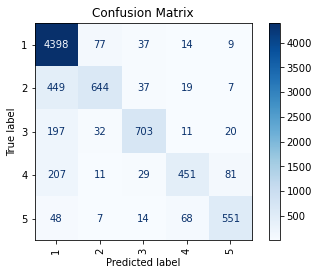

In [50]:
#Plotting normalized confusion matrix
class_names = ['credit_card','credit_reporting','debt_collection','mortgages_and_loans','retail_banking']
plt.figure(figsize=(10,10))
plot_confusion_matrix(rfc,X_test,y_test,cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title("Confusion Matrix")

In [90]:
import pickle
pickle.dump(rfc,open('rfc.pkl',"wb"))
pickle.dump(bow_vec,open('bow_vec.pkl',"wb"))

In [91]:
def predict(text_input):
    
    df = pd.DataFrame([text_input],columns=['text'])
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")
    df['text'] = df['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
    bow1 = bow_vec.transform( df['text'])
    final = pd.DataFrame(bow1.toarray())
    prediction = rfc.predict(final)
    if prediction == 1 :
        print("credit_reporting")
    elif prediction== 2:
        print("debt_collection")
    elif prediction== 3:
        print("mortgages_and_loans")
    elif prediction== 4:
        print("credit_card")
    else:
        print("retail_banking")
    

In [92]:
predict("victim identity someone use identity consent")

credit_reporting


In [93]:
predict("entered debt settlement agreement bank written")

debt_collection


In [54]:
dict = {'credit_reporting' : 1, 'debt_collection' : 2 , 'mortgages_and_loans' : 3, 'credit_card' : 4, 'retail_banking' : 5}